# Table of Contents
 <p><div class="lev1 toc-item"><a href="#For-visualization" data-toc-modified-id="For-visualization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>For visualization</a></div><div class="lev2 toc-item"><a href="#Camera-Calibration" data-toc-modified-id="Camera-Calibration-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Camera Calibration</a></div><div class="lev2 toc-item"><a href="#Visualize-Undistorted-Test-Image" data-toc-modified-id="Visualize-Undistorted-Test-Image-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualize Undistorted Test Image</a></div><div class="lev2 toc-item"><a href="#Perspective-Transform" data-toc-modified-id="Perspective-Transform-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Perspective Transform</a></div><div class="lev2 toc-item"><a href="#Color-Thresholding,-Binary-Thresholding" data-toc-modified-id="Color-Thresholding,-Binary-Thresholding-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Color Thresholding, Binary Thresholding</a></div><div class="lev2 toc-item"><a href="#Histogram-Filtering" data-toc-modified-id="Histogram-Filtering-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Histogram Filtering</a></div><div class="lev1 toc-item"><a href="#All-Pipeline" data-toc-modified-id="All-Pipeline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>All Pipeline</a></div><div class="lev1 toc-item"><a href="#Check-Movie" data-toc-modified-id="Check-Movie-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check Movie</a></div>

In [3]:
import sys
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# For visualization

For visualization, many method was revised a little.  
So If you wanna check pipeline, Please check **ALL Pipeline Section**

## Camera Calibration

In [2]:
def get_calibration_param(image_url):
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("finish get_calibration_param")
    return mtx, dist

def get_undistortion(distorted_img, mtx, dist):
    undist = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    return undist

def input_calibration_file(path="./calibration.npz"):
    try:
        calibratin_param = np.load(path)
        return calibration_param
    except IOError as e:
        raise IOError("Please Set Correct Calibration File")

In [5]:
if __name__ == "__main__":
    camera_matrix, dist_coeff = get_calibration_param('./camera_cal/calibration*.jpg')
    np.savez("./calibration.npz",mtx=camera_matrix, dist=dist_coeff)

finish get_calibration_param


## Visualize Undistorted Test Image

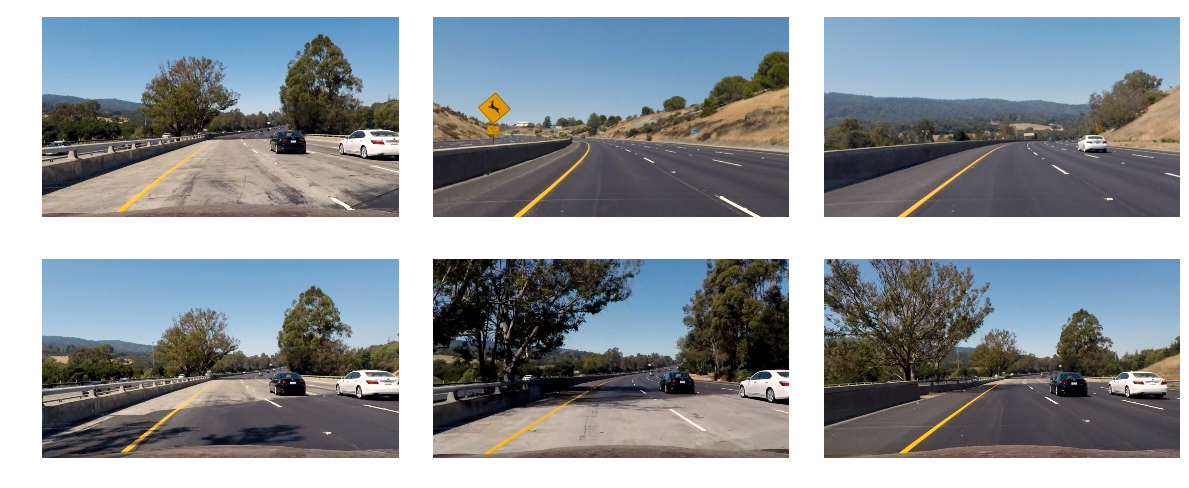

In [4]:
try:
    calibration_param = np.load('./calibration.npz')
except IOError as e:
    print("There is no file like path")
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            undist_img = get_undistortion(image, mtx, dist)
            axes[i, j].imshow(undist_img)
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

## Perspective Transform

In [6]:
class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))

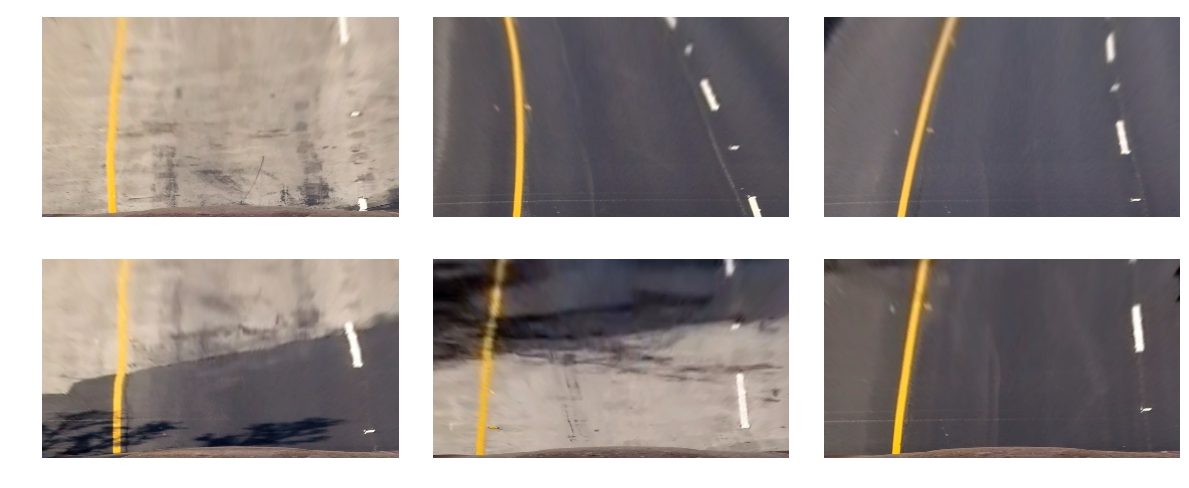

In [7]:
try:
    calibration_param = input_calibration_file()
except IOError as e:
    print(e)
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    src = np.float32([[490, 482],[810, 482],
                  [1250, 720],[40, 720]])

    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])

    bird_view_transformer = Perspective_Transform(src, dst)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    for i in range(2):
        for j in range(3):
            image = mpimg.imread("./test_images/test{}.jpg".format(str(i*3 + j + 1)))
            undist_img = get_undistortion(image, mtx, dist)
            bird_view = bird_view_transformer.transform(undist_img)
            axes[i, j].imshow(bird_view)
    fig.tight_layout()
    [ax.axis('off') for axe in axes for ax in axe]
    fig.subplots_adjust(left = None, right = None, top = None, bottom = None, wspace = 0.1, hspace = 0.1)

## Color Thresholding, Binary Thresholding

In [10]:
def get_s_binary(undist_img, thres=(110, 255)): 
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1
    s_binary = gaussian_blur(s_binary, kernel_size=21)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
    dir_binary =  np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    #dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.3, 1.8))    
    #slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=9) # 5

    return slope_binary

def color_slope_thres_conversion(undist_img):
    s_binary = get_s_binary(undist_img, thres=(150, 255))
    slope = get_slope(undist_img, orient='x',sobel_kernel=7, thres=(25, 255)) #3, 30

    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) | (slope == 1)] = 1
    
    return s_binary, slope, color_binary

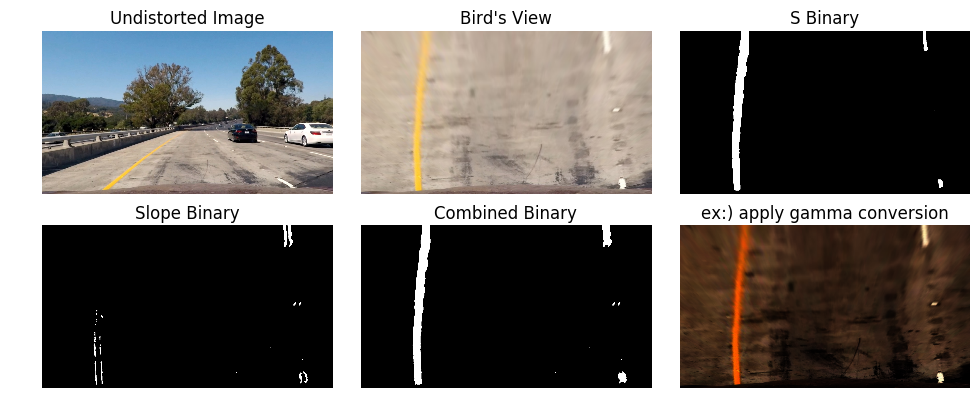

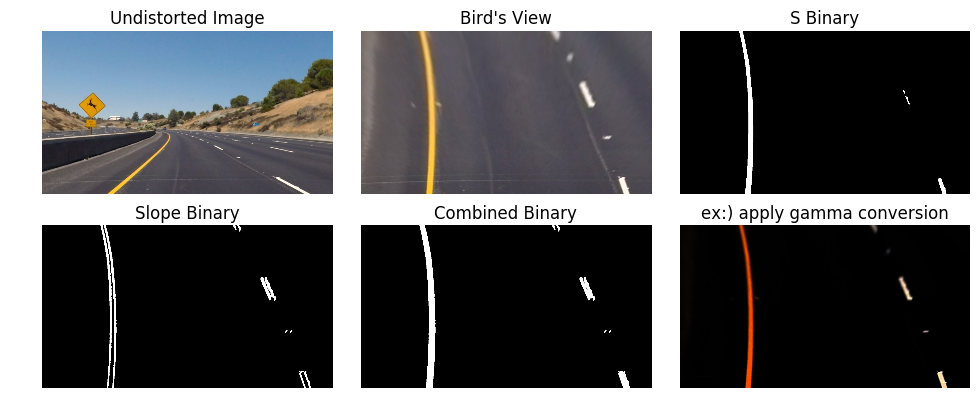

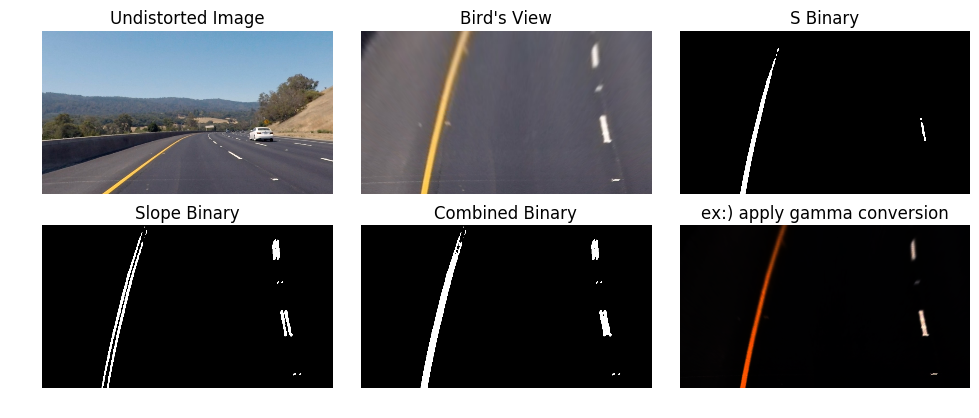

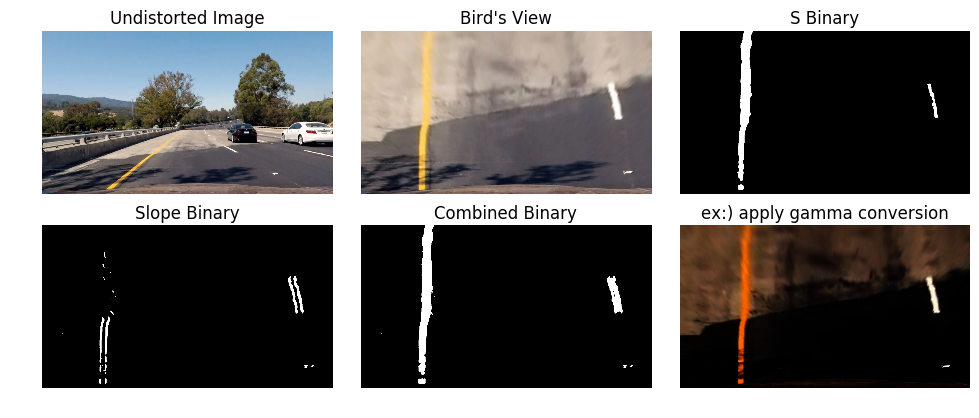

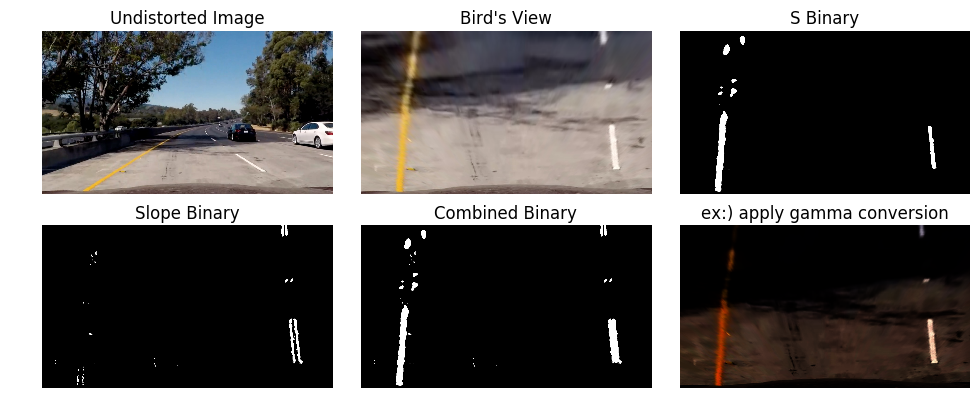

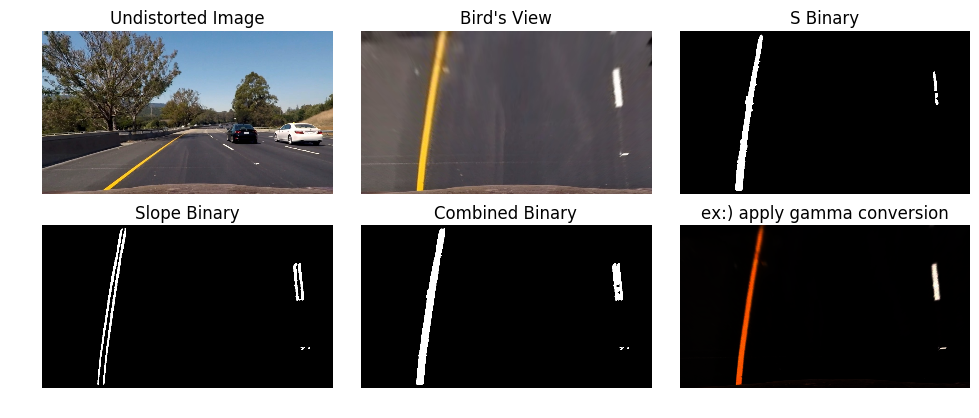

In [17]:
try:
    calibration_param = input_calibration_file()
except IOError as e:
    print(e)
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    src = np.array([[490, 482],[810, 482],
                  [1250, 720],[40, 720]], dtype=np.float32)
    dst = np.array([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]], dtype=np.float32)
    
    bird_view_transformer = Perspective_Transform(src, dst)

    for path in glob.glob("./test_images/test*.jpg"):
        fig, axes = plt.subplots(2, 3, figsize=(10, 4))
        distorted_img = mpimg.imread(path)
        undist_img = get_undistortion(distorted_img, mtx, dist)
        bird_view = bird_view_transformer.transform(undist_img)            
        s_binary, slope, conversion_img = color_slope_thres_conversion(bird_view)
        
        gamma = adjust_gamma(bird_view, 0.2)
        
        axes[0, 0].imshow(undist_img)
        axes[0, 0].set_title("Undistorted Image")
        axes[0, 1].imshow(bird_view)
        axes[0, 1].set_title("Bird's View")
        axes[0, 2].imshow(s_binary, cmap='gray')
        axes[0, 2].set_title("S Binary")
        axes[1, 0].imshow(slope, cmap='gray')
        axes[1, 0].set_title("Slope Binary")
        axes[1, 1].imshow(conversion_img, cmap='gray')
        axes[1, 1].set_title("Combined Binary")
        axes[1, 2].imshow(gamma, cmap='gray')
        axes[1, 2].set_title("ex:) apply gamma conversion")

        fig.tight_layout()
        [ax.axis('off') for axe in axes for ax in axe]
        fig.subplots_adjust(left = None, right = None, top = 1, bottom = None, wspace = 0.1, hspace = 0.1)

## Histogram Filtering

In [15]:
def histogram(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line = cal_poly(img, 0, boundary)
    right_fit_line = cal_poly(img, boundary, img.shape[1])
    yvals = np.arange(img.shape[0])
             
    return img, left_fit_line, right_fit_line, yvals

def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    fit_equation = np.polyfit(yvals, xvals, 2)
    yvals = np.arange(img.shape[0])
    fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
    return fit_line

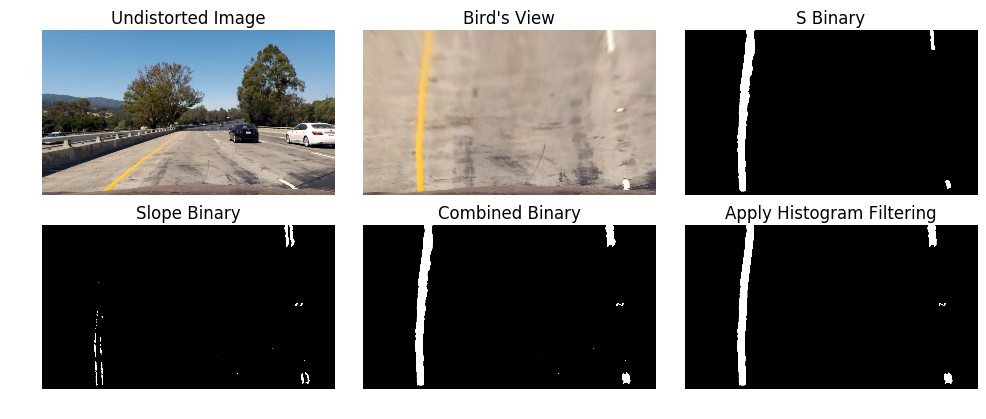

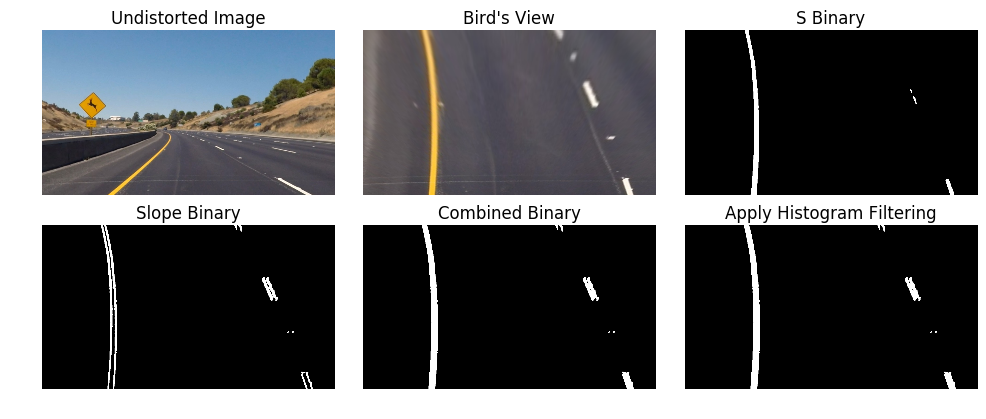

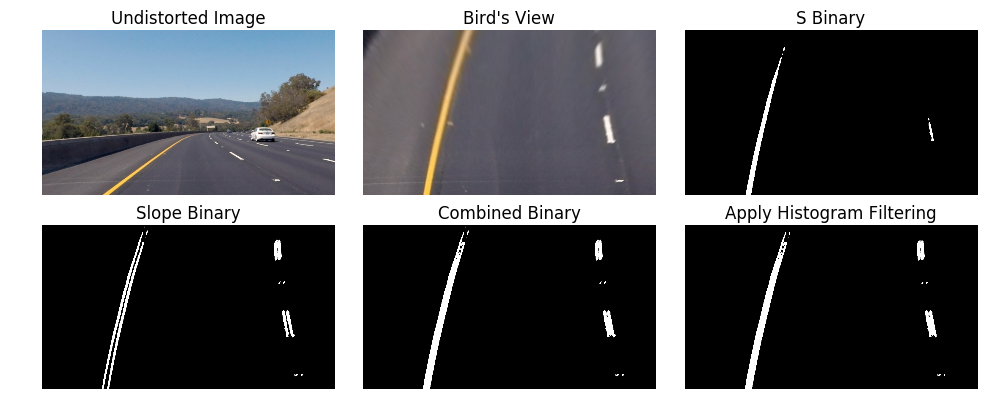

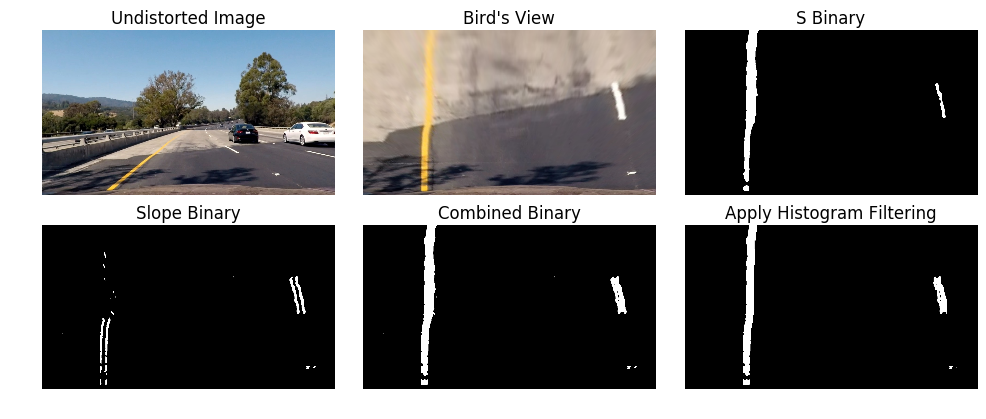

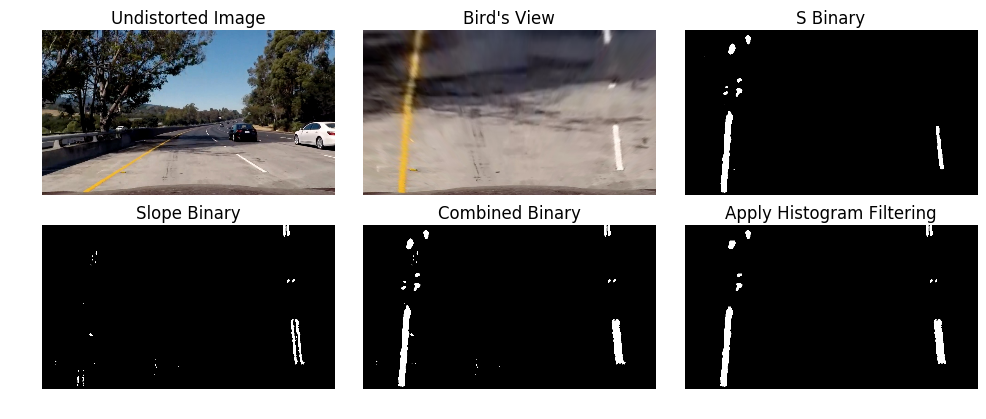

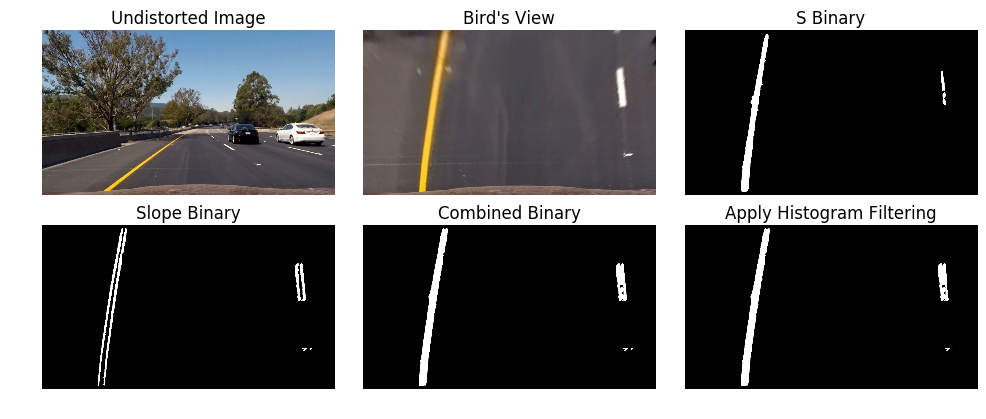

In [19]:
try:
    calibration_param = input_calibration_file()
except IOError as e:
    print(e)
else:
    mtx = calibration_param['mtx']
    dist = calibration_param['dist']
    
    src = np.array([[490, 482],[810, 482],
                  [1250, 720],[40, 720]], dtype=np.float32)
    dst = np.array([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]], dtype=np.float32)
    
    bird_view_transformer = Perspective_Transform(src, dst)

    for path in glob.glob("./test_images/test*.jpg"):
        fig, axes = plt.subplots(2, 3, figsize=(10, 4))
        distorted_img = mpimg.imread(path)
        undist_img = get_undistortion(distorted_img, mtx, dist)
        bird_view = bird_view_transformer.transform(undist_img)            
        s_binary, slope, conversion_img = color_slope_thres_conversion(bird_view)
        
        a = conversion_img.copy()
        
        final_img, left_lines, right_lines, yvals = histogram(a, xsteps=20, ysteps=25, window_width=15)
        new_image = np.zeros_like(final_img)
        for yv, ll in zip(yvals, left_lines):
            new_image[yv, ll-10:ll+10] = 1
        for yv, rl in zip(yvals, right_lines):
            new_image[yv, rl-10 : rl+10] = 1
        
        axes[0, 0].imshow(undist_img)
        axes[0, 0].set_title("Undistorted Image")
        axes[0, 1].imshow(bird_view)
        axes[0, 1].set_title("Bird's View")
        axes[0, 2].imshow(s_binary, cmap='gray')
        axes[0, 2].set_title("S Binary")
        axes[1, 0].imshow(slope, cmap='gray')
        axes[1, 0].set_title("Slope Binary")
        axes[1, 1].imshow(conversion_img, cmap='gray')
        axes[1, 1].set_title("Combined Binary")
        axes[1, 2].imshow(final_img, cmap='gray')
        axes[1, 2].set_title("Apply Histogram Filtering")
        
        fig.tight_layout()
        [ax.axis('off') for axe in axes for ax in axe]
        fig.subplots_adjust(left=None, right=None, top=1, bottom=None, wspace=0.1, hspace=0.1)

# All Pipeline

In [22]:
def get_calibration_param(image_url):
    """Compute camera calibration matrix and distortion coefficients given a set of chessboard images
          Args:
                image_url : 
         
    """
    images = glob.glob(image_url)

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    corner = (9, 6)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, corner, None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("finish get_calibration_param")
    return mtx, dist

def get_undistortion(distorted_img, mtx, dist):
    undist = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    return undist

def input_calibration_file(path="./calibration.npz"):
    try:
        calibration_param = np.load(path)
        return calibration_param['mtx'], calibration_param['dist']
    except IOError as e:
        print(e)
        raise IOError("Please Set Correct Calibration File")

class Perspective_Transform():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.inverse_M = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def transform(self, undist):
        return cv2.warpPerspective(undist, self.M, (undist.shape[1], undist.shape[0]))
    
    def inv_transform(self, undist):
        return cv2.warpPerspective(undist, self.inverse_M, (undist.shape[1], undist.shape[0]))
    
def get_s_binary(undist_img, thres=(110, 255)): #110
    hls = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    h = hls[:, :, 0]
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[((s >= thres[0]) & (s <= thres[1])) & (h <= 30)] = 1 #30
    s_binary = gaussian_blur(s_binary, kernel_size=21)#9
    return s_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
    dir_binary =  np.zeros_like(abs_grad_dir)
    dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def get_slope(undist_img, orient='x', sobel_kernel=3, thres = (0, 255)):
    undist_img = adjust_gamma(undist_img, 0.2)
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        slope = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    else:
        raise KeyError("select 'x' or 'y'")
        
    scale_factor = np.max(slope) / 255
    scale_slope = (slope / scale_factor).astype(np.uint8)
    slope_binary = np.zeros_like(scale_slope)
    slope_binary[(scale_slope >= thres[0]) & (scale_slope <= thres[1])] = 1
    
    #dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh=(0.3, 1.8))    
    #slope_binary[(dir_binary == 0)] = 0
    slope_binary = gaussian_blur(slope_binary, kernel_size=9) # 5

    return slope_binary

def color_slope_thres_conversion(undist_img):
    s_binary = get_s_binary(undist_img, thres=(150, 255))
    slope = get_slope(undist_img, orient='x',sobel_kernel=7, thres=(25, 255)) #3, 30

    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) | (slope == 1)] = 1
    
    return color_binary

def histogram_thresholding(img, xsteps=20, ysteps=40, window_width=10):
    def get_max_index_of_histogram(histogram, left_boundary, right_boundary, window_width=10):
        index_list = []
        side_histogram = histogram[left_boundary : right_boundary]
        for i in range(len(side_histogram) - window_width):
            index_list.append(np.sum(side_histogram[i : i + window_width]))
        index = np.argmax(index_list) + int(window_width / 2) + left_boundary
        return index
    
    xstride = img.shape[0] // xsteps
    ystride = img.shape[1] // ysteps 
    for xstep in range(xsteps):
        histogram = np.sum(img[xstride*xstep : xstride*(xstep+1), :], axis=0)
        boundary = int(img.shape[1] / 2)
        leftindex = get_max_index_of_histogram(histogram, 0, boundary, window_width=window_width)
        rightindex = get_max_index_of_histogram(histogram, boundary, img.shape[1], window_width=window_width)
        
        # mask image
        if histogram[leftindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), : leftindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), leftindex+ysteps+1 : boundary] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), : boundary] = 0
            
        if histogram[rightindex] >= 3:
            img[xstride*xstep : xstride*(xstep+1), boundary :rightindex-ysteps] = 0
            img[xstride*xstep : xstride*(xstep+1), rightindex+ysteps+1 :] = 0
        else:
            img[xstride*xstep : xstride*(xstep+1), boundary : ] = 0
            
    left_fit_line, left_line_equation = cal_poly(img, 0, boundary)
    right_fit_line, right_line_equation = cal_poly(img, boundary, img.shape[1])
           
    return img, left_fit_line, right_fit_line, left_line_equation, right_line_equation


def cal_poly(img, left_boundary, right_boundary):
    side_img = img[:, left_boundary: right_boundary]
    index = np.where(side_img == 1)
    yvals = index[0]
    xvals = index[1] + left_boundary
    if xvals.size != 0:
        fit_equation = np.polyfit(yvals, xvals, 2)
        yvals = np.arange(img.shape[0])
        fit_line = fit_equation[0]*yvals**2 + fit_equation[1]*yvals + fit_equation[2]
        return fit_line, fit_equation
    else:
        return 0, np.array([10000., 100., 100.])
    
def mask_image_by_lines(image, left_lines, right_lines, yvals):
    new_image = np.zeros_like(image)
    for yv, ll in zip(yvals, left_lines):
        new_image[yv, ll-10:ll+10] = 1
    for yv, rl in zip(yvals, right_lines):
        new_image[yv, rl-10 : rl+10] = 1
    return new_image

def add_lines_to_image(undist_img, new_image):
    index = np.where(new_image == 1)
    pt = np.vstack((index[1], index[0]))
    pt = np.transpose(pt)
    cv2.fillConvexPoly(undist_img, pt, (255, 93, 74))
    undist_img[new_image==1] = [255, 0, 0]
    return undist_img

In [26]:
class Line(object):
    def __init__(self):
        self.detected = False
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.bestx = None # average of x values of the fitted line over the last n iteration
        self.best_fit = None #average of polyminal coefficients over the last n iterations
        self.current_fit = [np.array([False])]
        self.current_x = None
        self.radius_of_curvature = None
        self.line_base_pos = None
        self.diffs = np.array([0, 0, 0], dtype="float")
        self.allx = None
        self.ally = None
    
class Line_detector(object):
    def __init__(self, calibration_path="./calibration.npz"):
        self.left_line = Line()
        self.right_line = Line()
        src = np.array([[490, 482],[810, 482],
                        [1250, 720],[40, 720]], dtype=np.float32)
        dst = np.array([[0, 0], [1280, 0], 
                        [1250, 720],[40, 720]], dtype=np.float32)
        self.bird_view_transformer =Perspective_Transform(src, dst)
        self.yvals = np.arange(720)
        self.detected = None
        self.count = 0
        
        try:
            self.camera_mtx, self.dist_coeff = input_calibration_file(path=calibration_path)
        except IOError as e:
            sys.exit()
    
    def get_filtered_img_and_cal_poly(self, converted_img, width=30):
        image = self.mask_image_by_average_lines(converted_img, width=width)
        _, self.left_line.current_fit = self.cal_poly(image, 0, int(image.shape[1] / 2))
        _, self.right_line.current_fit = self.cal_poly(image, int(image.shape[1] / 2), image.shape[1])
        return image

    def mask_image_by_average_lines(self, converted_img, width=30):
        image = np.zeros_like(converted_img)
        for yv, ll in zip(self.yvals, self.left_line.bestx):
            image[yv, ll-width:ll+width] = converted_img[yv, ll-width:ll+width]
        for yv, rl in zip(self.yvals, self.right_line.bestx):
            image[yv, rl-width:rl+width] = converted_img[yv, rl-width:rl+width]
        return image
    
    def mask_image_by_lines(self, original_image, width=10):
        image = np.zeros_like(original_image)
        for yv, ll in zip(self.yvals, self.left_line.bestx):
            image[yv, ll-width:ll+width] = 1
        for yv, rl in zip(self.yvals, self.right_line.bestx):
            image[yv, rl-width : rl+width] = 1
        return image
    
    def cal_poly(self, img, left_boundary, right_boundary):
        side_img = img[:, left_boundary: right_boundary].copy()
        index = np.where(side_img == 1)
        yvals = index[0]
        xvals = index[1] + left_boundary
        if xvals.size != 0:
            fit_equation = np.polyfit(yvals, xvals, 2)
            fit_line = fit_equation[0]*self.yvals**2 + fit_equation[1]*self.yvals + fit_equation[2]
            return fit_line, fit_equation
        else:
            return 0, np.array([10000., 100., 100.])
        
    def check_parallel(self):
        return True if (np.abs(self.left_line.current_fit[0] - self.right_line.current_fit[0]) < 0.01) else False
        
    def check_similarity(self, side='left'):
        if side == 'left':
            return True if (np.abs(self.left_line.current_fit[0] - self.left_line.best_fit[0]) < 0.0005) else False
        else:
            return True if (np.abs(self.right_line.current_fit[0] - self.right_line.best_fit[0]) < 0.0005) else False
            
    def check_line(self):
        return self.check_similarity(side='right') and self.check_similarity(side='left') and self.check_parallel()
    
    def cal_bestx_and_fit(self, weight=0.2):
        self.left_line.best_fit = self.left_line.best_fit * (1 - weight) + self.left_line.current_fit * weight
        self.left_line.bestx = self.left_line.best_fit[0]*self.yvals**2 + self.left_line.best_fit[1]*self.yvals + self.left_line.best_fit[2]
        self.right_line.best_fit = self.right_line.best_fit * (1 - weight) + self.right_line.current_fit * weight
        self.right_line.bestx = self.right_line.best_fit[0]*self.yvals**2 +  self.right_line.best_fit[1]*self.yvals + self.right_line.best_fit[2]
        self.count = 0
        
    def add_curvature_to_image(self, image):
        self.__cal_curvature()
        curvature = int((self.left_line.radius_of_curvature+self.right_line.radius_of_curvature)/2)
        cv2.putText(
            image, 'Radius of Curvature {}(m)'.format(curvature), 
                    (120,140), fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        return image
        
    def __cal_curvature(self):
        """Compute radius of curvature for each lane in meters"""
        ym_per_pix = 30./720 
        xm_per_pix = 3.7/700
        
        left_fit_cr = np.polyfit(self.yvals * ym_per_pix, self.left_line.bestx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(self.yvals * ym_per_pix, self.right_line.bestx * xm_per_pix, 2)
        
        self.left_line.radius_of_curvature = ((1 + (2*left_fit_cr[0]*np.max(self.yvals) + left_fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*left_fit_cr[0])
        self.right_line.radius_of_curvature = ((1 + (2*right_fit_cr[0]*np.max(self.yvals) + right_fit_cr[1])**2)**1.5) \
                                        /np.absolute(2*right_fit_cr[0])
       
    def add_place_to_image(self, image):
        place = (self.left_line.bestx[-1] + self.right_line.bestx[-1]) / 2
        diff_center = np.abs((image.shape[1] / 2 - place) * 3.7 / 700)
        
        if place > image.shape[1] / 2:
            cv2.putText(image, 'Vehicle is {:.2f}m left of center'.format(diff_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        else:
            cv2.putText(image, 'Vehicle is {:.2f}m right of center'.format(diff_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
        return image

    def process_image(self, distorted_image):
        undist_img = get_undistortion(distorted_image, self.camera_mtx, self.dist_coeff)
        bird_view = self.bird_view_transformer.transform(undist_img)            
        converted_img = color_slope_thres_conversion(bird_view)    
        if self.detected:
            final_bird_view_img = self.get_filtered_img_and_cal_poly(converted_img, width=50)
            if self.check_line():
                self.cal_bestx_and_fit()
            else:
                self.count += 1
                if self.count == 2:
                    self.detected = None
                    self.count = 0
        else:
            final_bird_view_img, left_line, right_line, left_line_equation, right_line_equation = \
                histogram_thresholding(converted_img, xsteps=20, ysteps=25, window_width=15)
            self.left_line.current_fit = left_line_equation
            self.right_line.current_fit = right_line_equation
            
            if not self.check_parallel():
                self.detected = False
            else:
                self.left_line.bestx = left_line
                self.left_line.best_fit = left_line_equation
                self.right_line.bestx = right_line
                self.right_line.best_fit = right_line_equation
                self.detected = True
                        
        final_bird_view_img = self.mask_image_by_lines(final_bird_view_img)
        new_image = self.bird_view_transformer.inv_transform(final_bird_view_img)
        undist_img = add_lines_to_image(undist_img, new_image)
        undist_img = self.add_curvature_to_image(undist_img)
        undist_img = self.add_place_to_image(undist_img)
        return undist_img

In [24]:
if __name__ == "__main__":
    camera_matrix, dist_coeff = get_calibration_param('./camera_cal/calibration*.jpg')
    np.savez("./calibration.npz",mtx=camera_matrix, dist=dist_coeff)
    output = './output.mp4'
    clip1 = VideoFileClip('./project_video.mp4')
    ld = Line_detector()
    white_clip = clip1.fl_image(ld.process_image)
    white_clip.write_videofile(output, audio=False)
    print("process Finished. Please view %s" % output)

finish get_calibration_param
[MoviePy] >>>> Building video ./output.mp4
[MoviePy] Writing video ./output.mp4


100%|█████████▉| 1260/1261 [02:54<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output.mp4 

process Finished. Please view ./output.mp4


# Check Movie

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("./output.mp4"))